In [52]:
#coding:utf-8
%matplotlib inline
'''
色彩均衡
参考：https://github.com/mohammades303/Color_correction
'''
import cv2
import numpy as np
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
from scipy import signal
import os
import pyopencl as cl
import logging
from joblib import Parallel, delayed
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [53]:
src = cv2.cvtColor(cv2.imread('datas/color_check.jpg'),cv2.COLOR_BGR2RGB)

In [54]:
r = src[:,:,0]
g = src[:,:,1]
b = src[:,:,2]
print(r.shape)

(420, 560)


In [55]:
# 单通道直方图均衡化
r = cv2.equalizeHist(r)
g = cv2.equalizeHist(g)
b = cv2.equalizeHist(b)

In [56]:
dst = cv2.merge([r,g,b])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

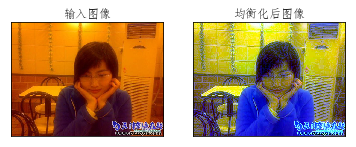

In [57]:
plt.subplot(121)
plt.title('输入图像')
plt.imshow(src)
plt.xticks([]),plt.yticks([])
plt.subplot(122)
plt.title('均衡化后图像')
plt.imshow(dst)
plt.xticks([]),plt.yticks([])

In [58]:

def rgb2hsi(data):
    """
    Converts array from rgb color space to hsi color space
    Returns data in hsi format.
    """
    logging.info("Converting from rgb to hsi.")
    i = np.mean(data, axis=2)

    s = np.copy(i)
    m = i == 0
    s[m] = 0
    rgbMin = np.amin(data, axis=2)
    s[~m] = 1 - rgbMin[~m]/i[~m]

    #TODO This is slow. Refactor so numpy can optimize this
    def hfunk(r,g,b):
        r, g, b = float(r), float(g), float(b)
        if r == g == b:
            return 0
        numerator= r - g/2 - b/2
        denominator=np.sqrt(r**2 + g**2 + b**2 - r*g - r*b - g*b)
        result = np.degrees(np.arccos(numerator/denominator))
        if g >= b:
            return result
        else:
            return 360 - result

    hfunk = np.vectorize(hfunk)
    r, g, b = data[:,:,0], data[:,:,1], data[:,:,2]
    h = hfunk(r,g,b)

    hsi = np.dstack((h,s,i))
    return cv2.convertScaleAbs(hsi)

def hsi2rgb(data):
    """
    Converts array from hsi color space to rgb color space.
    Returns data in rgb format.
    """
    logging.info("Converting from hsi to rgb.")
    h,s,i = data[:,:,0], data[:,:,1], data[:,:,2]
    r,g,b = np.copy(h),np.copy(s),np.copy(i)

    """
    In case the reader is not familar with numpy masks,
    here is an explanation.
    For every element in `r` and `h` (in the code below)
    if the `h` element equals 0, evaluate the expression
    on the right of the equals sign.
    So in this first code block, every element of `r`
    where the same index in `h` equals 0, the element
    in `r` will get new values.
    The other arrays (`g`,`b`,`i` and `s`) work the same
    since the mask is applied.
    The arrays need to have the same size and shape for
    this to work.
    """
    mask = h == 0
    r[mask], g[mask], b[mask] = \
            i[mask] + 2*i[mask]*s[mask], \
            i[mask] - i[mask]*s[mask], \
            i[mask] - i[mask]*s[mask], \

    m = (0 < h) & (h < 120)
    r[m], g[m], b[m] = \
            i[m]+i[m]*s[m]*(np.cos(np.radians(h[m]))/np.cos(np.radians(60 - h[m]))),\
            i[m]+i[m]*s[m]*(1-(np.cos(np.radians(h[m]))/np.cos(np.radians(60 - h[m])))),\
            i[m]-i[m]*s[m]

    m = h == 120
    r[m], g[m], b[m] = \
            i[m] - i[m]*s[m],\
            i[m] + 2*i[m]*s[m],\
            i[m] - i[m]*s[m]

    m = (120 < h) & (h < 240)
    r[m], g[m], b[m] = \
            i[m] - i[m]*s[m],\
            i[m]+i[m]*s[m]*(np.cos(np.radians(h[m] - 120))/np.cos(np.radians(180 - h[m]))),\
            i[m] + i[m]*s[m]*(1 - (np.cos(np.radians(h[m] - 120))/np.cos(np.radians(180 - h[m]))))

    m = h == 240
    r[m], g[m], b[m] = \
            i[m] - i[m] * s[m],\
            i[m] - i[m] * s[m],\
            i[m] + 2*i[m]*s[m]

    m = (240 < h) & (h <= 360)
    r[m], g[m], b[m] = \
            i[m] + i[m]*s[m]*(1 - np.cos(np.radians(h[m] - 240))/np.cos(np.radians(300 - h[m]))),\
            i[m] - i[m]*s[m],\
            i[m] + i[m]*s[m]*(np.cos(np.radians(h[m] - 240))/np.cos(np.radians(300 - h[m])))

    return cv2.convertScaleAbs(np.dstack((r,g,b)))

In [59]:
hsi = rgb2hsi(src)
rgb = hsi2rgb(hsi)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

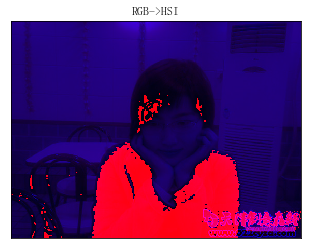

In [60]:
plt.imshow(hsi)
plt.title('RGB->HSI')
plt.xticks([]),plt.yticks([])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

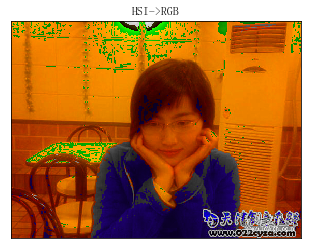

In [61]:
plt.imshow(rgb)
plt.title('HSI->RGB')
plt.xticks([]),plt.yticks([])

In [62]:
channels = cv2.split(hsi)
h = cv2.equalizeHist(channels[0])
s = cv2.equalizeHist(channels[1])
i = cv2.equalizeHist(channels[2])
hsi_eq = cv2.merge([h,s,i])
rgb = hsi2rgb(hsi_eq)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

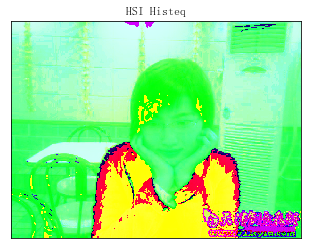

In [63]:
plt.imshow(hsi_eq)
plt.title('HSI Histeq')
plt.xticks([]),plt.yticks([])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

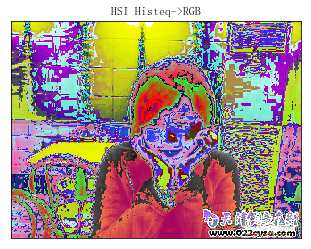

In [64]:
plt.imshow(cv2.convertScaleAbs(rgb))
plt.title('HSI Histeq->RGB')
plt.xticks([]),plt.yticks([])

In [67]:
def rgb2hsi_2(img):
	m,n = img.shape[:2]
	img_hsi = np.zeros((m,n,3),np.float)
	b = np.zeros((m,n),np.float)
	g = np.zeros((m,n),np.float)
	r = np.zeros((m,n),np.float)
	b[:,:] = img[:,:,0]
	g[:,:] = img[:,:,1]
	r[:,:] = img[:,:,2]
	img_hsi[:,:,2] = (b + g + r)/3
	for i in range(m):
		for j in range(n):
			if img[i,j,0] == img[i,j,1] == img[i,j,2]:
				img_hsi[i,j,0] = 0
				img_hsi[i,j,1] = 0
			else:
				img_hsi[i,j,1] = 1 - 3.0*min(b[i,j],g[i,j],r[i,j])/((b[i,j]+g[i,j]+r[i,j]))
				numerator = 0.5*(2.0*r[i,j]-b[i,j]-g[i,j])
				temp1 = (r[i,j]-g[i,j])**2
				temp2 = (r[i,j]-b[i,j])*(g[i,j]-b[i,j])
				denominator = float(np.power(temp1+temp2, 0.5))
				theta = np.arccos(float(numerator)/float(denominator))*180.0/np.pi
				if b[i,j] > g[i,j]:
					img_hsi[i,j,0] = 360 - theta
				else:
					img_hsi[i,j,0] = theta
	return cv2.convertScaleAbs(img_hsi)
def hsi2rgb_2(img_hsi):
	m,n = img_hsi.shape[:2]
	img = np.zeros((m,n,3),np.float)
	temp1 = img_hsi[:,:,2]*(1 - img_hsi[:,:,1])
	temp_h = (img_hsi[:,:,0] - (img_hsi[:,:,0]//120)*120)*np.pi/180.0
	temp2 = (img_hsi[:,:,1]*np.cos(temp_h)/np.cos(np.pi/3 - temp_h) + 1)*img_hsi[:,:,2]
	temp3 = 3.0 * img_hsi[:,:,2] - (temp1 + temp2)
	for i in range(m):
		for j in range(n):
			if 0 <= img_hsi[i,j,0] < 120:
				img[i,j,0] = temp1[i,j]
				img[i,j,1] = temp3[i,j]
				img[i,j,2] = temp2[i,j]
			elif 120 <= img_hsi[i,j,0] < 240:
				img[i,j,0] = temp3[i,j]
				img[i,j,1] = temp2[i,j]
				img[i,j,2] = temp1[i,j]
			elif 240 <= img_hsi[i,j,0] < 360:
				img[i,j,0] = temp2[i,j]
				img[i,j,1] = temp1[i,j]
				img[i,j,2] = temp3[i,j]
	return cv2.convertScaleAbs(img)

In [71]:
hsi = rgb2hsi_2(src)
rgb = hsi2rgb_2(hsi)
channels = cv2.split(hsi)
h = cv2.equalizeHist(channels[0])
s = cv2.equalizeHist(channels[1])
i = cv2.equalizeHist(channels[2])
hsi_eq = cv2.merge([h,s,i])
rgb = hsi2rgb(hsi_eq)

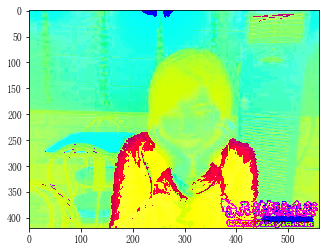

In [72]:
plt.imshow(hsi_eq)

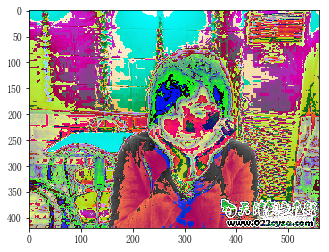

In [73]:
plt.imshow(rgb)

In [ ]:
class ColorConversion():
    def __init__(self, context, path="datas/cl/ColorConversion.cl"):
        file = open(path,"r")
        code = file.read()
        self.prg = cl.Program(context, code).build()
        self.rgb2lms_kernel = self.prg.rgb2lms
        self.lms2rgb_kernel = self.prg.lms2rgb
        self.rgb2hsi_kernel = self.prg.rgb2hsi
        self.hsi2rgb_kernel = self.prg.hsi2rgb

    def rgb2lms(self, queue, rgb, lms,wait_for=None):
        self.rgb2lms_kernel.set_args(rgb.gpu_buffer, lms.gpu_buffer, rgb.shape_gpu)
        return cl.enqueue_nd_range_kernel(queue, self.rgb2lms_kernel, (rgb.shape[0],rgb.shape[1]), None, wait_for=wait_for)

    def lms2rgb(self, queue, lms, rgb, wait_for=None):
        self.lms2rgb_kernel.set_args(lms.gpu_buffer, rgb.gpu_buffer, rgb.shape_gpu)
        return cl.enqueue_nd_range_kernel(queue, self.lms2rgb_kernel, (rgb.shape[0],rgb.shape[1]), None, wait_for=wait_for)

    def rgb2hsi(self, queue, rgb, hsi,wait_for=None):
        self.rgb2hsi_kernel.set_args(rgb.gpu_buffer, hsi.gpu_buffer, rgb.shape_gpu)
        return cl.enqueue_nd_range_kernel(queue, self.rgb2hsi_kernel, (rgb.shape[0],rgb.shape[1]), None, wait_for=wait_for)

    def hsi2rgb(self, queue, hsi, rgb,wait_for=None):
        self.hsi2rgb_kernel.set_args(hsi.gpu_buffer, rgb.gpu_buffer, rgb.shape_gpu)
        return cl.enqueue_nd_range_kernel(queue, self.hsi2rgb_kernel, (rgb.shape[0],rgb.shape[1]), None, wait_for=wait_for)

    @staticmethod
    def rgb2lms_cpu(rgb):
        r = rgb[0] / 255.0
        g = rgb[1] / 255.0
        b = rgb[2] / 255.0

        if r > 0.04045:
            r= pow(((r + 0.055) / 1.055), 2.4)
        else:
            r = r / 12.92

        if g > 0.04045:
            g= pow(((g + 0.055) / 1.055), 2.4)
        else:
            g = g / 12.92

        if b > 0.04045:
            b = pow(((b + 0.055) / 1.055), 2.4)
        else:
            b = b / 12.92

        r *= 100.0
        g *= 100.0
        b *= 100.0

        # sRGB, Illuminant = D65
        x = (r * 0.4124564) + (g * 0.3575761) + (b * 0.1804375)
        y = (r * 0.2126729) + (g * 0.7151522) + (b * 0.0721750)
        z = (r * 0.0193339) + (g * 0.1191920) + (b * 0.9503041)

        l = 0.7328* x + 0.4296 * y - 0.1624 * z
        m = -0.7036* x + 1.6975* y + 0.0061* z
        s = 0.0030* x + 0.0136* y + 0.9834* z

        return [l,m,s]

    @staticmethod
    def rgb2xyz_cpu(rgb):
        r = rgb[0] / 255.0
        g = rgb[1] / 255.0
        b = rgb[2] / 255.0

        if r > 0.04045:
            r = pow(((r + 0.055) / 1.055), 2.4)
        else:
            r = r / 12.92

        if g > 0.04045:
            g = pow(((g + 0.055) / 1.055), 2.4)
        else:
            g = g / 12.92

        if b > 0.04045:
            b = pow(((b + 0.055) / 1.055), 2.4)
        else:
            b = b / 12.92

        r *= 100.0
        g *= 100.0
        b *= 100.0

        # sRGB, Illuminant = D65
        x = (r * 0.4124564) + (g * 0.3575761) + (b * 0.1804375)
        y = (r * 0.2126729) + (g * 0.7151522) + (b * 0.0721750)
        z = (r * 0.0193339) + (g * 0.1191920) + (b * 0.9503041)

        return [x,y,z]

    @staticmethod
    def xyz2rgb_cpu(xyz):

        x = xyz[0] / 100.0
        y = xyz[1] / 100.0
        z = xyz[2] / 100.0

        # sRGB, Illuminant = D65
        r = (x * 3.2404542) + (y * -1.5371385) + (z * -0.4985314)
        g = (x * -0.9692660) + (y * 1.8760108) + (z * 0.0415560)
        b = (x * 0.0556434) + (y * -0.2040259) + (z * 1.0572252)

        if r > 0.0031308:
            r = 1.055 * (pow(r, (1.0 / 2.4))) - 0.055
        else:
            r = 12.92 * r

        if g > 0.0031308:
            g = 1.055 * (pow(g, (1.0 / 2.4))) - 0.055
        else:
            g = 12.92 * g

        if b > 0.0031308:
            b = 1.055 * (pow(b, (1.0 / 2.4))) - 0.055
        else:
            b = 12.92 * b

        if r > 1.0:
            r = 255.0
        elif r < 0.0:
            r = 0.0
        else:
            r = r * 255.0

        if g > 1.0:
            g = 255.0
        elif g < 0.0:
            g = 0.0
        else:
            g = g * 255.0

        if b > 1.0:
            b = 255.0
        elif b < 0.0:
            b = 0.0
        else:
            b = b * 255.0

        return [r, g, b]

    @staticmethod
    def lms2rgb_cpu(lms):
        l = lms[0]
        m = lms[1]
        s = lms[2]

        x = 1.096124* l - 0.278869* m + 0.182745* s
        y = 0.454369* l + 0.473533* m + 0.072098* s
        z = -0.009628* l - 0.005698* m + 1.015326* s

        x = x / 100.0
        y = y / 100.0
        z = z / 100.0

        # sRGB, Illuminant = D65
        r = (x * 3.2404542) + (y * -1.5371385) + (z * -0.4985314)
        g = (x * -0.9692660) + (y * 1.8760108) + (z * 0.0415560)
        b = (x * 0.0556434) + (y * -0.2040259) + (z * 1.0572252)

        if r > 0.0031308:
            r = 1.055 * (pow(r, (1.0 / 2.4))) - 0.055
        else:
            r = 12.92*r

        if g > 0.0031308:
            g = 1.055 * (pow(g, (1.0 / 2.4))) - 0.055
        else:
            g = 12.92*g

        if b > 0.0031308:
            b = 1.055 * (pow(b, (1.0 / 2.4))) - 0.055
        else:
            b = 12.92*b

        if r > 1.0:
            r = 255.0
        elif r < 0.0:
            r = 0.0
        else:
            r = r*255.0

        if g > 1.0:
            g = 255.0
        elif g < 0.0:
            g = 0.0
        else:
            g = g*255.0

        if b > 1.0:
            b = 255.0
        elif b < 0.0:
            b = 0.0
        else:
            b = b*255.0

        return [r,g,b]

In [ ]:
# Whitepoints from https://de.mathworks.com/help/images/ref/whitepoint.html
    # Conversion to CAT02 for chromatic adaption from D65 to x
xyz_C = [98.07, 100.00, 118.22] # Cold
xyz_D65 = [95.04, 100.00, 108.88] # Normal - cold
xyz_E = [100.0, 100.0, 100.0] # Normal
xyz_D55 = [95.68, 100.00, 92.14] # Normal - warm
xyz_50 = [96.42, 100.00, 82.51] # Warm
xyz_A = [109.85, 100.00, 35.58] # Extra warm

rgb = ColorConversion.xyz2rgb_cpu(xyz_C)
lms = ColorConversion.rgb2lms_cpu(rgb)
print(rgb)
print(lms)